## Import Libraries

In [3]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from urllib.request import urlopen
import scipy.stats as sps
import statsmodels.sandbox.distributions.extras as ssde
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import Data

In [4]:
#Initialize empty df
df = DataFrame()

#Iterate over each year LeBron played
for year in range(2004, 2019, 1):
    #BeautfulSoup the bb-ref page
    url = 'https://www.basketball-reference.com/players/j/jamesle01/gamelog/' + str(year)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    
    #Scrape the column names to a list
    column_names = [i.getText() for i in soup.findAll('th', limit = 30)][1:]
    
    #Scrape the game logs
    data_rows = soup.findAll('tr')[35:]
    
    #Turn the data_rows object to a DataFrame
    year_df = DataFrame([[td.getText() for td in data_rows[i].findAll('td')] for i in range(len(data_rows))], columns = column_names)
    year_df['Year'] = year
    
    #Add the one-year DataFrame to the cumulative DataFrame
    df = df.append(year_df)

In [5]:
#Clean the data up
df = df[['Year', 'PTS', 'AST', 'TRB']].dropna().convert_objects(convert_numeric=True)

## Descriptive Statistics and Graphs

In [336]:
#Statistics on LeBron's statlines
print('Average Statline:', array(df[['PTS', 'AST', 'TRB']].mean().round(1)))

print('\nTotal Games:', len(df[['PTS', 'AST', 'TRB']]))
print('Total Unique Games:', len(df[['PTS', 'AST', 'TRB']].drop_duplicates()))

Average Statline: [27.2  7.2  7.4]

Total Games: 1121
Total Unique Games: 928


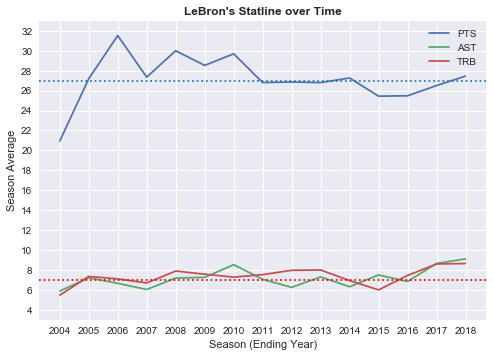

In [368]:
#Graph of LeBron's average statline over time
df.groupby('Year').mean().plot()

plt.axhline(27, ls = 'dotted', color = '#1f77b4')
plt.axhline(7, ls = 'dotted', color = 'red')

plt.yticks(range(4, 34, 2))
plt.xticks(range(2004, 2019, 1))

plt.ylim(3,33)

plt.xlabel('Season (Ending Year)')
plt.ylabel("Season Average")
plt.title("LeBron's Statline over Time", fontweight = 'bold')

plt.savefig('lebron_multivariate/statline_time_plot', dpi = 250)

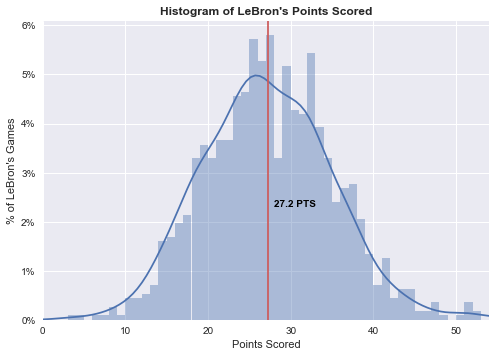

In [78]:
sns.distplot(df['PTS'], bins = range(0, 61, 1))

plt.axvline(27.2, color = 'indianred')

plt.yticks([x/100 for x in range(0, 7, 1)], [str(x) + '%' for x in range(0, 7, 1)])
plt.xlim(0,27*2)

plt.xlabel('Points Scored')
plt.ylabel("% of LeBron's Games")
plt.title("Histogram of LeBron's Points Scored", fontweight = 'bold')

plt.text(28, 0.023, '27.2 PTS', fontweight = 'bold', color = 'black')

plt.savefig('lebron_multivariate/points_hist', dpi = 250)

## Statistics

In [13]:
#Initialize some variables
prob_statline = 1
cumulative_dict = {}
probability_dict = {}
single_game_probability_dict = {}

#Iterate over each year LeBron played
for i in range(2004, 2019, 1):
    #Calculate the mean vector and the covariance matrix for a single year
    df_one_year = df.loc[df['Year'] == i, ['PTS', 'AST', 'TRB']]
    mu = df_one_year.mean()
    cov = df_one_year.cov()
    
    #Estimate the CDF for a 27-7-7 game
    prob_statline_one_year = ssde.mvnormcdf(lower = [26.5, 6.5, 6.5], mu = mu, cov = cov, upper = [27.5, 7.5, 7.5], maxpts = 1000000000)
    
    #Store variables
    prob_statline *= np.power((1 - prob_statline_one_year), len(df_one_year))
    cumulative_dict[i] = prob_statline
    probability_dict[i] = np.power((1 - prob_statline_one_year), len(df_one_year))
    single_game_probability_dict[i] = prob_statline_one_year

In [14]:
print("The odds LeBron would not have a 27-7-7 game so far: ", round(100*prob_statline, 2), '%', sep = '')

The odds LeBron would not have a 27-7-7 game so far: 31.87%


In [98]:
corr_table = df[['PTS', 'AST', 'TRB']].corr().round(2)
corr_table.iloc[0,1:] = ''
corr_table.iloc[1,2] = ''
corr_table.iloc[1,1] = '1.00'
corr_table.iloc[2,2] = '1.00'
corr_table

,PTS,AST,TRB
PTS,1.00,,
AST,-0.03,1.00,
TRB,0.15,0.18,1.00


## Statistics Graphs

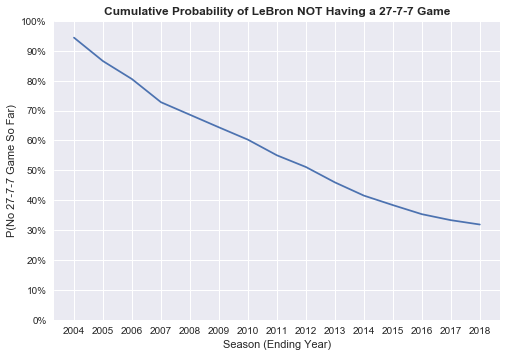

In [15]:
#Cumulative probability LeBron has not had a 27-7-7 game so far
plt.style.use('seaborn')

Series(cumulative_dict).plot()

plt.yticks([x/100 for x in range(0, 110, 10)], [str(x) + '%' for x in range(0, 110, 10)])
plt.xticks(range(2004, 2019, 1))

plt.xlabel('Season (Ending Year)')
plt.ylabel("P(No 27-7-7 Game So Far)")
plt.title('Cumulative Probability of LeBron NOT Having a 27-7-7 Game', fontweight = 'bold')

plt.savefig('lebron_multivariate/cumulative_prob_plot', dpi = 250)

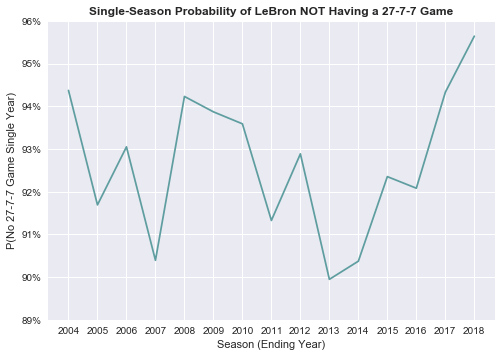

In [19]:
#Single-season probability of LeBron not having a 27-7-7 game that season 
Series(probability_dict).plot(color = 'cadetblue')

plt.yticks([x/100 for x in range(89, 97, 1)], [str(x) + '%' for x in range(89, 97, 1)])
plt.xticks(range(2004, 2019, 1))

plt.xlabel('Season (Ending Year)')
plt.ylabel("P(No 27-7-7 Game Single Year)")
plt.title('Single-Season Probability of LeBron NOT Having a 27-7-7 Game', fontweight = 'bold')

plt.savefig('lebron_multivariate/single_year_plot', dpi = 250)

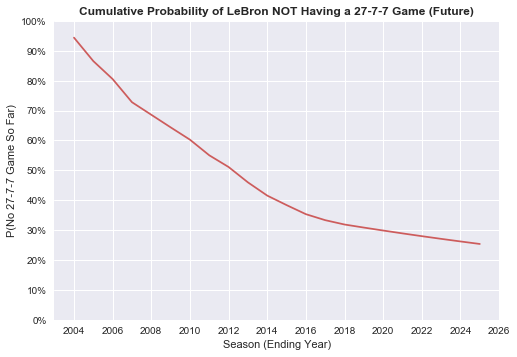

In [26]:
#Cumulative probability graph extended into the future 7 years
future_dict = cumulative_dict.copy()

for i in range(1, 8, 1):
    future_dict[i + 2018] = cumulative_dict[2018] * np.power((1 - single_game_probability_dict[2018]), 60*i)

Series(future_dict).plot(color = 'indianred')

plt.yticks([x/100 for x in range(0, 110, 10)], [str(x) + '%' for x in range(0, 110, 10)])
plt.xticks(range(2004, 2028, 2))

plt.xlabel('Season (Ending Year)')
plt.ylabel("P(No 27-7-7 Game So Far)")
plt.title('Cumulative Probability of LeBron NOT Having a 27-7-7 Game (Future)', fontweight = 'bold')

plt.savefig('lebron_multivariate/cumulative_prob_future_plot', dpi = 250)

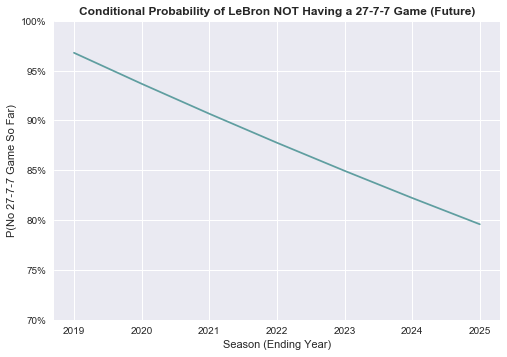

In [32]:
#Cumulative probability graph extended 7 years, but conditional that we already have seen LeBron's first 15 years.
future_dict_conditional = {}

for i in range(1, 8, 1):
    future_dict_conditional[i + 2018] = np.power((1 - single_game_probability_dict[2018]), 60*i)

Series(future_dict_conditional).plot(color = 'cadetblue')

plt.yticks([x/100 for x in range(70, 105, 5)], [str(x) + '%' for x in range(70, 105, 5)])
plt.xticks(range(2019, 2026, 1))

plt.xlabel('Season (Ending Year)')
plt.ylabel("P(No 27-7-7 Game So Far)")
plt.title('Conditional Probability of LeBron NOT Having a 27-7-7 Game (Future)', fontweight = 'bold')

plt.savefig('lebron_multivariate/conditional_prob_future_plot', dpi = 250)